# Importing the required libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization, Dropout
from tensorflow.keras.models import load_model
import os
import time 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data and do preliminary cleaning
directory = 'data'

filepath = os.path.join(directory,'insider-network-traffic.csv')
df = pd.read_csv(filepath)

In [3]:
df

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,01-03-2018 08:17,115307855,5,0,0,0,0,0,...,0,1812348.0,0.0,1812348,1812348,56700000.0,6010057.622,61000000,52500000,Benign
1,0,0,01-03-2018 08:20,60997457,2,0,0,0,0,0,...,0,0.0,0.0,0,0,61000000.0,0.0,61000000,61000000,Benign
2,67,17,01-03-2018 08:17,61149019,5,0,1500,0,300,300,...,8,3530939.0,0.0,3530939,3530939,19200000.0,12500000.0,32600000,7999725,Benign
3,0,0,01-03-2018 08:22,60997555,2,0,0,0,0,0,...,0,0.0,0.0,0,0,61000000.0,0.0,61000000,61000000,Benign
4,0,0,01-03-2018 08:24,61997503,3,0,0,0,0,0,...,0,999909.0,0.0,999909,999909,61000000.0,0.0,61000000,61000000,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331096,0,0,01-03-2018 12:59,118494070,31,0,0,0,0,0,...,0,0.0,0.0,0,0,0.0,0.0,0,0,Benign
331097,2634,6,01-03-2018 12:59,114340,2,1,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
331098,3389,6,01-03-2018 12:59,1404866,8,7,1132,1581,661,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
331099,3389,6,01-03-2018 12:59,3966663,14,7,1386,392,680,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign


In [4]:
# get count of each label
print(df['Label'].value_counts())

Benign     238037
insider     93063
Label           1
Name: Label, dtype: int64


# Data Preprocessing

In [5]:
# convert columns to correct data types

df[['Dst Port','Protocol','Label']] = df[['Dst Port','Protocol','Label']].astype(str)

df[df.columns.difference(['Dst Port','Protocol','Label'])] = df[df.columns.difference(['Dst Port','Protocol','Label'])].apply(pd.to_numeric, errors='coerce')


In [6]:
df = df.drop(['Timestamp'],axis=1)
df.replace([np.inf, -np.inf], np.nan, inplace=True)  # for handling missing or infinite values in the data
df = df.dropna()

In [7]:
df.replace({'insider':1,'Benign':0}, inplace = True)

In [8]:
print(df['Label'].value_counts())

0    235778
1     92403
Name: Label, dtype: int64


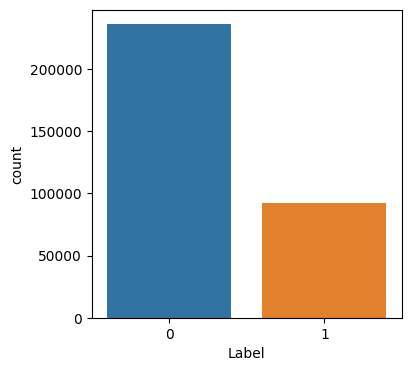

In [9]:
plt.figure(figsize=(4, 4))
sns.countplot(x='Label', data=df)
plt.show()

In [10]:
df.shape

(328181, 79)

In [11]:
# get the data types of each column
dtypes = df.dtypes

# loop through the columns and convert to float
for column in df.columns:
    if dtypes[column] != 'float':
        df[column] = df[column].astype('float')

In [12]:
dtypes

Dst Port          object
Protocol          object
Flow Duration    float64
Tot Fwd Pkts     float64
Tot Bwd Pkts     float64
                  ...   
Idle Mean        float64
Idle Std         float64
Idle Max         float64
Idle Min         float64
Label              int64
Length: 79, dtype: object

# Data Splitting

In [13]:
train = df.loc[df['Label'] == 0].sample(frac=.80, random_state=123)
x_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1]

In [14]:
test = df.sample(frac=.20, random_state=123)
x_test = test.iloc[:, :-1]
y_test = test.iloc[:, -1]

# Normalization of data

MinMaxScaler is a data normalization technique that scales the data to a fixed range between 0 and 1. It transforms the features by subtracting the minimum value and dividing by the range of the feature.

In [15]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))

In [16]:
# Fitting the Scaler over the x_train and x_test
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [17]:
x_train.shape

(188622, 78)

In [18]:
y_train.shape

(188622,)

In [19]:
x_test.shape

(65636, 78)

In [20]:
y_test.shape

(65636,)

# Model Training

# LSTM

LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) architecture that is widely used for sequential data analysis, such as time series forecasting, natural language processing, speech recognition, and more.

Unlike traditional RNNs, which suffer from the vanishing gradient problem and have difficulties in remembering long-term dependencies, LSTMs use a memory cell and several gates (input gate, forget gate, output gate) to control the flow of information and selectively remember or forget previous inputs.

LSTMs have been shown to be effective in modeling time series data with long-term dependencies and are often used in anomaly detection, where the goal is to identify patterns in the data that deviate significantly from the expected behavior.

In [21]:
# Define the model architecture
model = Sequential()

model.add(LSTM(128, input_shape=(78,1), return_sequences=True, activation='relu'))

model.add(LSTM(64, return_sequences=True, activation='relu'))

model.add(LSTM(32, return_sequences=True, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

In [22]:
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [23]:
# Add batch normalization and dropout regularization 
model.add(BatchNormalization())
model.add(Dropout(0.2))

In [24]:
#Train the model
model.fit(x_train, y_train, epochs=10, batch_size=32)

# Save the model

In [25]:
model.save('models/models5-3L-BD.h5')

# Load the model

In [24]:
model = load_model(r'E:\final_yr_project\models\model5-3L-BD.h5')

# Evaluate the model

In [25]:
metrics = model.evaluate(x_test, y_test)

2052/2052 [==============================] - 76s 37ms/step - loss: 0.1753 - accuracy: 0.7696


In [26]:
print(metrics)

[0.17526791989803314, 0.7695624232292175]


# Predict the anomalies

In [27]:
anomalies = model.predict(x_test)

2052/2052 [==============================] - 76s 36ms/step


In [28]:
y_pred = anomalies.ravel()   # returns a flattened array (a 1D array)
y_pred

array([0.22057056, 0.19190407, 0.22019577, ..., 0.22372818, 0.22110462,
       0.22457981], dtype=float32)

In [29]:
# Define threshold value
threshold = 0.5
anomalies = np.where(y_pred > threshold)

In [30]:
y_pred = [1 if pred > threshold else 0 for pred in y_pred]

# Observing the metric

In [31]:
accuracy = []

In [32]:
acc = accuracy_score(y_test, y_pred)
acc

0.7695624352489487

In [33]:
accuracy.append(acc)

# Isolation Forest


Isolation Forest is an anomaly detection algorithm based on the concept of decision trees. It randomly selects a feature and a split value to partition the data into two parts, one with anomalies and one without. It repeats this process until each anomaly is isolated in its own partition, making it an outlier. It does not make any assumptions about the distribution of the data and can handle high-dimensional data efficiently.

In [34]:
train = df.loc[df['Label'] == 0].sample(frac=.80, random_state=123)
test = df.drop(train.index)

In [35]:
tf = train[train.columns.difference(['Label'])].sample(frac=.01, random_state=123)
y_test = test.iloc[:, -1]
x_test = test.iloc[:, :-1]

In [36]:
start = time.time()
rng = np.random.RandomState(42)

# fit the model
iF = IsolationForest(max_samples=2000, random_state=rng, contamination=0.10)
iF.fit(tf)
print(time.time() - start)

0.4694688320159912


In [37]:
# predicting the test data
y_pred = iF.predict(x_test)

In [38]:
y_pred

array([-1, -1, -1, ..., -1, -1, -1])

In [39]:
y_pred = [1 if x == -1 else 0 for x in y_pred]

In [40]:
y_test.shape

(139559,)

In [41]:
y_test = y_test.astype(int)

In [42]:
# observing the accuracy
acc = accuracy_score(y_test, y_pred)
acc

0.4965856734427733

In [43]:
accuracy.append(acc)

# One-class SVM

One-class SVM is a type of support vector machine that learns a decision boundary around the normal data points in a dataset, with the aim of identifying the anomalies as the points outside the decision boundary. One-class SVM is suitable for unsupervised anomaly detection tasks, where there is no labeled data for training a supervised model.

In [44]:
start = time.time()
# fit the model
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(tf)
print(time.time() - start)

0.48748016357421875


In [45]:
# predicting the test data
y_pred = clf.predict(x_test)

In [46]:
y_pred

array([-1, -1, -1, ..., -1, -1, -1], dtype=int64)

In [47]:
y_pred = [1 if score == -1 else 0 for score in y_pred]

In [48]:
y_test.shape

(139559,)

In [49]:
# observing the accuracy
acc = accuracy_score(y_test, y_pred)
acc

0.6621070658287893

In [50]:
accuracy.append(acc)

# Visualising the results

In [51]:
results = pd.DataFrame({  'Algorithm'       : ['LSTM','Isolation Forest','One-class SVM'],
                          'Accuracy'        : accuracy
                          })
print(results)

          Algorithm  Accuracy
0              LSTM  0.769562
1  Isolation Forest  0.496586
2     One-class SVM  0.662107


<AxesSubplot: xlabel='Algorithm', ylabel='Accuracy'>

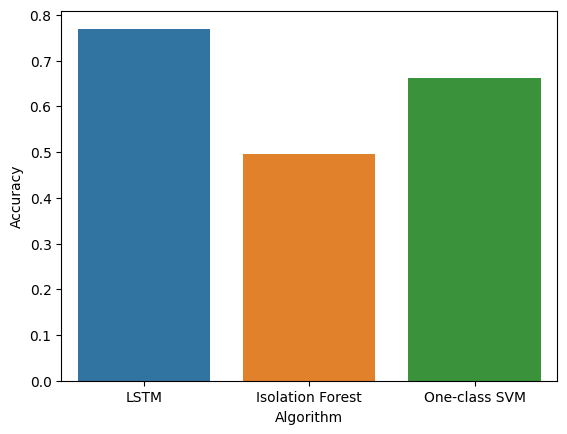

In [52]:
sns.barplot(x='Algorithm', y='Accuracy', data=results)

# 